In [1]:
import pymongo
import os
import configparser
import pandas as pd
import pickle
from bson import json_util, ObjectId
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment
import IPython.display as ipd
import librosa
import librosa.display as ld

/opt/anaconda3/lib/python3.6/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Database interactions

In [2]:
config = configparser.ConfigParser()
config.read(os.path.abspath(os.path.join(".ini")))

client = pymongo.MongoClient(config['PROD']['DB_URI'])
db = client['melon-tunes']
collection = db['user-data']

print(db.test)

documents = list(collection.find({}))
print(len(documents))

relevantDocs = list(filter(lambda doc: hasattr(doc, 'sweetness') and hasattr(doc, 'crispness'), documents))
print(len(relevantDocs))

Collection(Database(MongoClient(host=['cluster0-shard-00-01.tki2f.mongodb.net:27017', 'cluster0-shard-00-02.tki2f.mongodb.net:27017', 'cluster0-shard-00-00.tki2f.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, retrywrites=True, w='majority', authsource='admin', replicaset='atlas-c96fac-shard-0', tls=True), 'melon-tunes'), 'test')
23
0


# Audio

In [3]:
import wave

In [4]:
wav_obj = wave.open('data/sample-08-01-2022-2.wav', 'rb')
wav_obj.getframerate()

48000

In [5]:
wav_obj.getnchannels()

1

In [6]:
n_samples = wav_obj.getnframes()
n_samples

380928

In [7]:
frames = wav_obj.readframes(n_samples)
wave_array = np.frombuffer(frames, dtype=np.int16)

In [8]:
wave_array

array([ 0,  0,  0, ..., -1, -2, -1], dtype=int16)

In [9]:
n_samples = wav_obj.getnframes()
framerate = wav_obj.getframerate()
times = np.linspace(0, n_samples/framerate, num=n_samples)

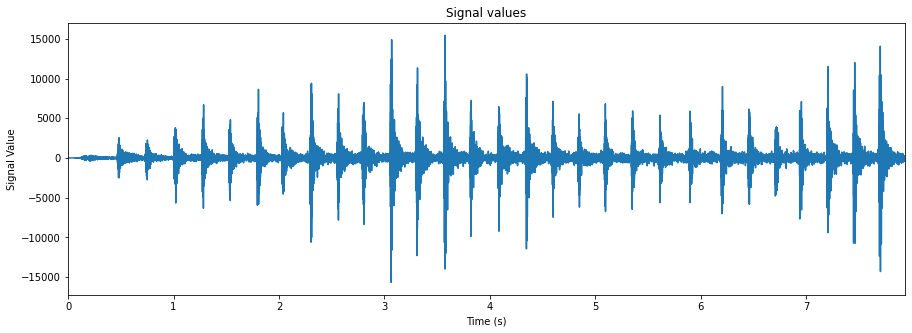

In [10]:
plt.figure(figsize=(15,5))
plt.plot(times, wave_array)
plt.title('Signal values')
plt.ylabel('Signal Value')
plt.xlabel('Time (s)')
plt.xlim(0, n_samples/framerate)
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


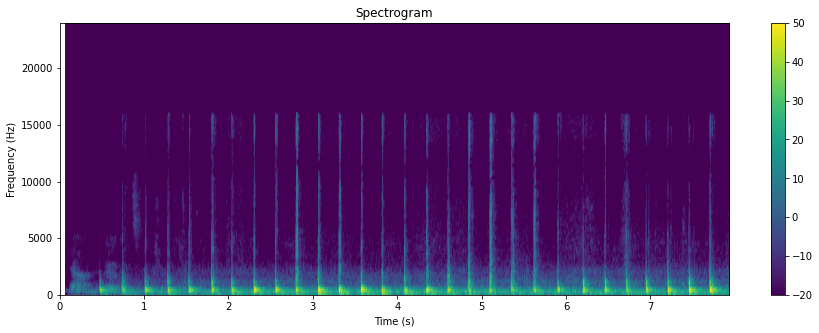

In [11]:
plt.figure(figsize=(15,5))
plt.specgram(wave_array, Fs=framerate, vmin=-20, vmax=50)
plt.title('Spectrogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, n_samples/framerate)
plt.colorbar()
plt.show()

# Breaking up clip
### We would like to split up a clip into each different "tap" clip

In [12]:
# Our initial assumption is that a new "tap" clip will occur slightly before any given local maximum and 
# through the next local concave down hump

In [26]:
clipsIndices = []

def find_max_vals(arr):
    minTempVal = 0
    max_vals = {}
    for i in range(len(arr)):
        if arr[i] > 0:
            if arr[i] < minTempVal:
                max_vals[i] = minTempVal
            minTempVal = arr[i]
    return max_vals

max_vals = find_max_vals(wave_array)

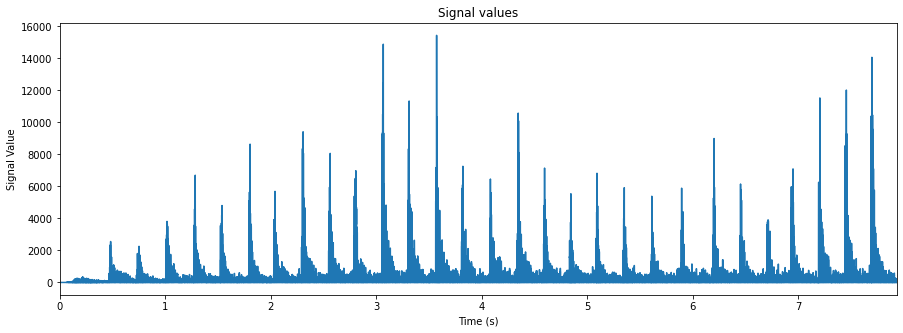

In [28]:
def view_max_vals(max_vals, regular_vals, times):

    max_vals_inserted_array = [max_vals[i] if i in max_vals else 0 for i in range(len(regular_vals))]

    plt.figure(figsize=(15,5))
    plt.plot(times, max_vals_inserted_array)
    plt.title('Signal values')
    plt.ylabel('Signal Value')
    plt.xlabel('Time (s)')
    plt.xlim(0, n_samples/framerate)
    plt.show()

view_max_vals(max_vals, wave_array, times)